In [1]:
import os
import requests

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
import regionmask
from metpy.plots.declarative import (MapPanel,PlotObs,PanelContainer,ContourPlot,FilledContourPlot)
from datetime import datetime, timedelta

sns.set(font_scale=1.3)
sns.set_style("white")

In [2]:
# Get netcdf file

prcp_data_path = 'http://weather.eas.cmich.edu:8080/repository/opendap/08b17143-0623-4088-9c1c-32c2d5e58f93/entry.das'

# Open up the data

with xr.open_dataset(prcp_data_path) as file_nc:
    daily_prcp_xr = file_nc

# View xarray object

daily_prcp_xr

<xarray.Dataset>
Dimensions:  (lon: 300, lat: 120, time: 26943)
Coordinates:
  * lon      (lon) float32 230.1 230.4 230.6 230.9 ... 304.1 304.4 304.6 304.9
  * lat      (lat) float32 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * time     (time) datetime64[ns] 1948-01-01 1948-01-02 ... 2021-10-06
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:             CPC Unified Gauge-Based Analysis of Daily Precipitatio...
    Conventions:       COARDS
    description:       Gridded daily Precipitation
    platform:          Observations
    Comments:          Preciptation is accumulated from 12z of previous day t...
    history:           originally created RT starting 04/2010 by CAS from dat...
    dataset_title:     CPC Unified Gauge-Based Analysis of Daily Precipitatio...
    References:        http://www.psl.noaa.gov/data/gridded/data.unified.dail...
    _CoordSysBuilder:  ucar.nc2.dataset.conv.COARDSConvention

In [3]:
# Download natural earth data which contains state boundaries to generate area of interest

et.data.get_data(
    url="https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip")

# Go to where data was downloaded

os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

states_path = "earthpy-downloads/ne_50m_admin_1_states_provinces_lakes"
states_path = os.path.join( "data",
    states_path, "ne_50m_admin_1_states_provinces_lakes.shp")

#Read in the states using the GeoPandas package

states_gdf = gpd.read_file(states_path)

In [4]:
# Select the state of Michigan from the natural earth data

mi_aoi = states_gdf[states_gdf.name == "Michigan"]

# Print the total spatial extent for Michigan (west_lon, south_lat, east_lon, north_lat)

mi_aoi.total_bounds

array([-90.41258814,  41.70143447, -82.41723144,  48.17592773])

In [5]:
# Separate the lats from the lons
# Notice that the longitude values have negative numbers

aoi_lat = [float(mi_aoi.total_bounds[1]), float(mi_aoi.total_bounds[3])]
aoi_lon = [float(mi_aoi.total_bounds[0]), float(mi_aoi.total_bounds[2])]

aoi_lat, aoi_lon

([41.701434467279654, 48.175927734374994],
 [-90.41258813514587, -82.41723144155574])

In [6]:
# The precip files use a global lat/lon so adjust values accordingly
# You can see the precip files lat/lon range when you viewed the xarray object above 

aoi_lon[0] = aoi_lon[0] + 360
aoi_lon[1] = aoi_lon[1] + 360

In [7]:
# Specify the time you want 

date = "2019-07-20"
date_obj = datetime.strptime(date, '%Y-%m-%d')
tlist = [date_obj]

In [8]:
#Find the points in the precip data that are inside Michigan
#Use them to create a mask

mi_mask = regionmask.mask_3D_geopandas(mi_aoi,
                                         daily_prcp_xr.lon,
                                        daily_prcp_xr.lat)

In [9]:
#Create a new data array that includes only the precip data over Michigan for the specified time

prcp_masked = daily_prcp_xr["precip"].sel(time=date, 
                                              lon=slice(aoi_lon[0], aoi_lon[1]), 
                                              lat=slice(aoi_lat[0], aoi_lat[1])).where(mi_mask)

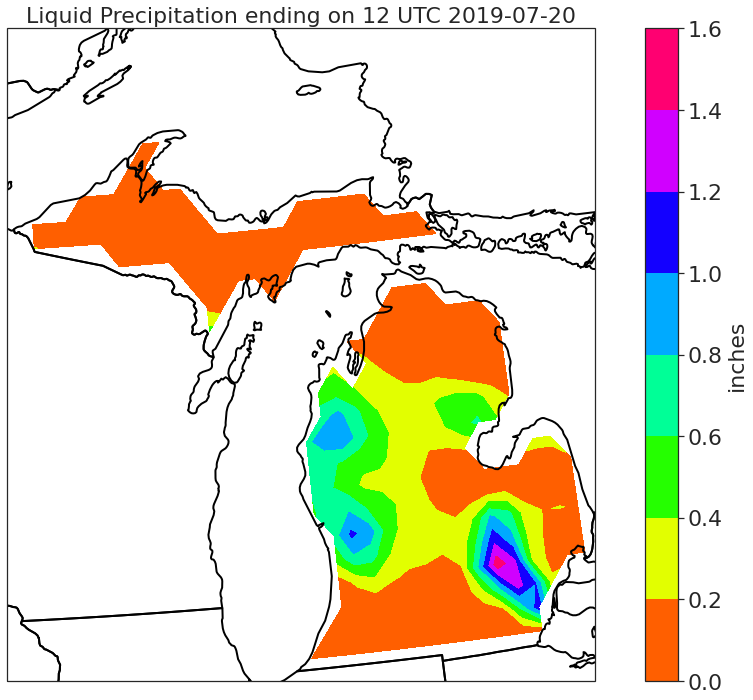

In [10]:
#Make a contour plot of the daily data using Matplotlib

fig = plt.figure(figsize=(18,12))

proj = ccrs.LambertConformal(standard_parallels=[33,45])
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.STATES,linewidth=2.0)
ax.set_title('Liquid Precipitation ending on 12 UTC %s' % date, fontsize=22)

cs = ax.contourf(prcp_masked['lon'],prcp_masked['lat'],prcp_masked[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
cb = plt.colorbar(cs, ax=ax)
cb.ax.tick_params(labelsize=22) 
cb.set_label('inches', size=22)
plt.show()

In [11]:
#Create a new data array that includes only the precip data over Michigan for all times 1948-present
#Then take the means at each point over the entire 

prcp_masked_all = daily_prcp_xr["precip"].sel(lon=slice(aoi_lon[0], aoi_lon[1]), lat=slice(aoi_lat[0], aoi_lat[1])).where(mi_mask)
prcp_masked_mean = prcp_masked_all.mean(axis=0)

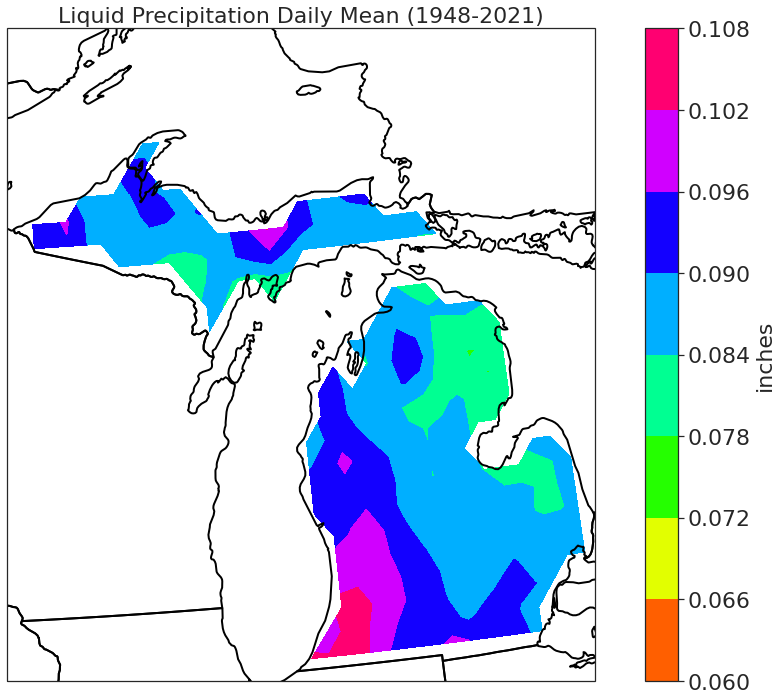

In [12]:
#Make a contour plot of the mean data using Matplotlib

fig = plt.figure(figsize=(18,12))

proj = ccrs.LambertConformal(standard_parallels=[33,45])
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.STATES,linewidth=2.0)
ax.set_title('Liquid Precipitation Daily Mean (1948-2021)', fontsize=22)

cs = ax.contourf(prcp_masked_mean['lon'],prcp_masked_mean['lat'],prcp_masked_mean[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
cb = plt.colorbar(cs, ax=ax)
cb.ax.tick_params(labelsize=22) 
cb.set_label('inches', size=22)
plt.show()

In [13]:
#From all the data, replace all nonzero values with NaN, leaves us with only days with rain

nozero = prcp_masked_all.where(prcp_masked_all[:,:,:]>0)

#Group the data by year and take the average of the year, using only days with rain

prcp_masked_yrly_mean = nozero.groupby("time.year").mean()


#Group the data by year and sum up the values for each year, using only days with rain

prcp_masked_yrly_total = nozero.groupby("time.year").sum()

#Average the total annual precipitation across all points in Michigan

prcp_masked_yrly_mean_state = prcp_masked_yrly_total.mean(dim=['lat','lon'])

#Select year 2019 for plotting

mean_precip_2019 = prcp_masked_yrly_mean.sel(year=2019)

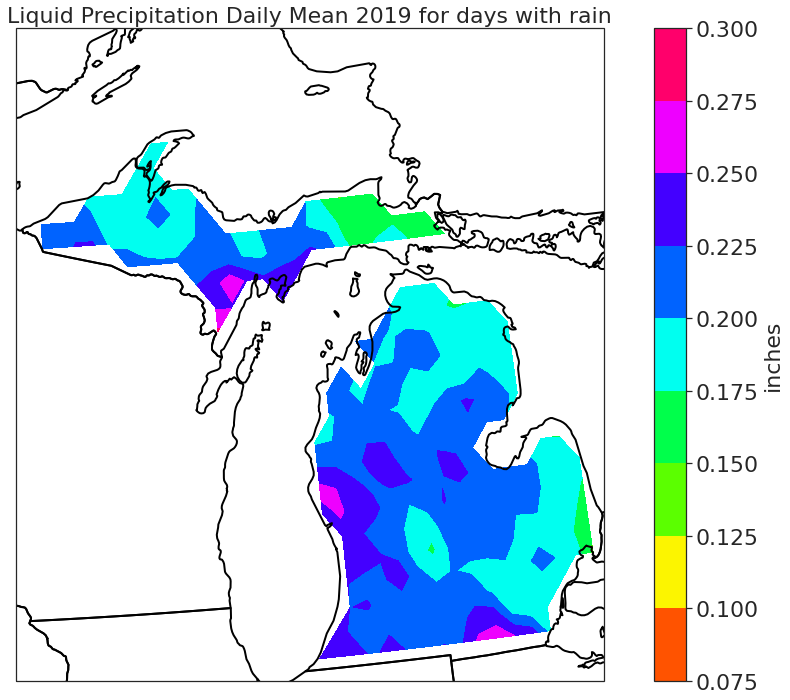

In [14]:
#Make a contour plot of the mean 2019 data for data with only days where rain occurred

fig = plt.figure(figsize=(18,12))

proj = ccrs.LambertConformal(standard_parallels=[33,45])
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.STATES,linewidth=2.0)
ax.set_title('Liquid Precipitation Daily Mean 2019 for days with rain', fontsize=22)

cs = ax.contourf(mean_precip_2019['lon'],mean_precip_2019['lat'],mean_precip_2019[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
cb = plt.colorbar(cs, ax=ax)
cb.ax.tick_params(labelsize=22) 
cb.set_label('inches', size=22)
plt.show()

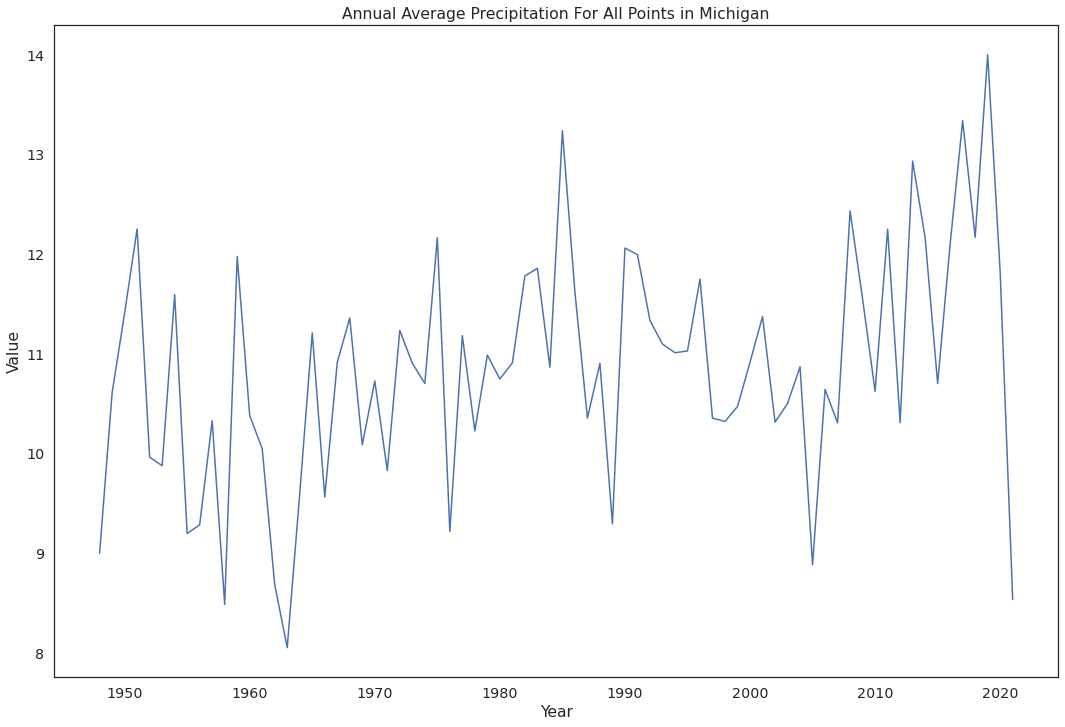

In [15]:
#Make a time series plot of the average annual precipitation for the whole state

plt.rcParams.update({'font.size':20})
plt.figure(figsize=(18,12))
plt.plot(prcp_masked_yrly_mean_state['year'], prcp_masked_yrly_mean_state[:]*0.0393701)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("Annual Average Precipitation For All Points in Michigan")
plt.show()

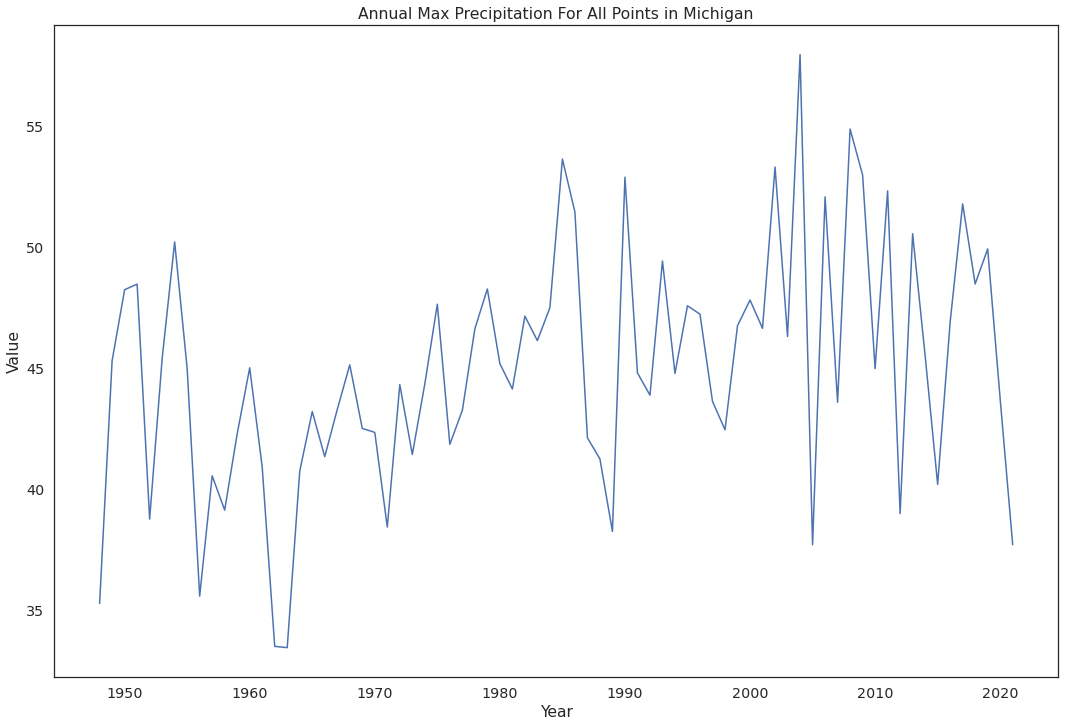

In [16]:
#make a time series of the grid point with largest value for each year 
# possibly use prcp_masked_all = daily_prcp_xr["precip"].sel(lon=slice(aoi_lon[0], aoi_lon[1]), lat=slice(aoi_lat[0], aoi_lat[1])).where(mi_mask)
#this is all the precip data for MI for that time range, we need highest yearly
# possibly use if or for loop- there is a note similar to this in 315 notes, should run time series with that
#LOOK AT NOTES ON IPAD_MORE DIRECTIONs FOR THIS

prcp_masked_yrly_total = nozero.groupby("time.year").sum()

prcp_masked_yrly_high = prcp_masked_yrly_total.max(dim=['lat','lon'])

#max is function for highest value- this resource is on the shanelynn website you have bookmarked 

#need to split the data by the year then find largest value in each year
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(18,12))
plt.plot(prcp_masked_yrly_high['year'], prcp_masked_yrly_high[:]*0.0393701)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("Annual Max Precipitation For All Points in Michigan")
plt.show()

#THIS WORKS- but do the values make sense?? COME BACK TO THIS AFTER TRYING 2 AND 3 

## Work backwards to verify the accuracy of the plot above
## Will need to change the path where files are saved from /home/baxte1ma to /home/megan

In [60]:
#Find the index of the year with the highest precip value in the chart above (gives 56)
print(prcp_masked_yrly_high.argmax())
#Use this index to find out the value and the year it occurs in (gives 1471 mm in 2004)
print(prcp_masked_yrly_high[56])
#Find the index of the lat lon values that correspond to the point that had the highest value in 2004 
#Gives coordinates of 18, 15
print(np.unravel_index(prcp_masked_yrly_total[56,:,:,0].argmax(), prcp_masked_yrly_total.shape))
#Confirm that the value of precip at these coordinates is the same as that found above (1471 mm) 
print(prcp_masked_yrly_total[56,18,15,0])

<xarray.DataArray 'precip' ()>
array(56)
<xarray.DataArray 'precip' (region: 1)>
array([1471.9264], dtype=float32)
Coordinates:
  * region   (region) int64 71
    year     int64 2004
(0, 18, 15, 0)
<xarray.DataArray 'precip' ()>
array(1471.9264, dtype=float32)
Coordinates:
    lat      float64 46.38
    lon      float64 273.4
    region   int64 71
    year     int64 2004


In [62]:
#Select all of the data for 2004 from the original dataset and print the dimensions of the data
year=nozero.sel(time=slice('2004-01-01', '2004-12-31'))
print(year.shape)
#Select just the data at the identified point (366 values for 2004), and drop the NaN values that are outside Michigan
#Print it out to have a look
out=year[:,18,15,0].dropna(dim='time')
print(year[:,18,15,0].dropna(dim='time'))
#Convert the data to a pandas dataframe and then output it as a CSV
out.to_dataframe()
csv.to_csv('/home/baxte1ma/notebooks/megan.csv')
#Open the CSV in Excel and Sum the values yourself, make sure they match 1471 mm

(366, 26, 32, 1)
<xarray.DataArray 'precip' (time: 255)>
array([1.1830117e+00, 1.0402006e+01, 1.8255199e+00, 2.5320454e+00,
       2.7333195e+00, 5.4671826e+00, 2.1458147e+00, 3.5589473e+00,
       1.2306640e+00, 1.6677879e+00, 6.9870529e+00, 9.5317955e+00,
       5.6390123e+00, 6.9010048e+00, 7.6753247e-01, 9.7573309e+00,
       6.5666504e+00, 8.8396969e+00, 7.1705370e+00, 8.8980484e-01,
       1.0618916e+01, 1.1549246e+01, 6.0825706e+00, 3.2449265e+00,
       7.3802775e-01, 3.8686028e+00, 4.4444380e+00, 4.4238138e+00,
       8.4089298e+00, 5.7544379e+00, 5.1976782e-01, 1.6103504e-02,
       7.4318428e+00, 3.7945721e+00, 1.7144511e-02, 1.2301950e+00,
       7.0038362e+00, 1.6600205e+00, 1.0185018e+00, 1.5050765e+00,
       1.4902810e+00, 5.5812544e-01, 6.5908575e+00, 2.0092037e+00,
       6.0185349e-01, 4.7145987e+00, 2.1659037e+01, 7.1162067e-02,
       3.8352108e+00, 1.4293017e+00, 8.3278418e+00, 1.1591835e+00,
       5.9919298e-01, 4.6698942e+00, 2.9600927e+01, 1.2846944e+00,
     

In [ ]:
#test block, trying to find issue with opening/ reading monthly values
#THIS RUNS GOOD FOR PUTTING OUT JANUARY DATA
prcp_masked_monthly_mean = nozero.groupby("time.month").mean("time") 
#print(prcp_masked_monthly_mean)

#for loop for mean precip that loops through each month

#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
#fig.suptitle('Sharing x per column, y per row')
#ax1.plot(x, y)
#ax2.plot(x,y)

mean_precip_jan = prcp_masked_monthly_mean.sel(month= 1)
#can try ot loop through or 
mean_precip_feb = prcp_masked_monthly_mean.sel(month=2)
    
#fig = plt.figure(figsize=(18,12))
fig.suptitle("Monthly precip averages")

#fig, (ax1,ax2)= plt.subplot(1,2,sharex=True)

proj = ccrs.LambertConformal(standard_parallels=[33,45])
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.STATES,linewidth=2.0)
ax.set_title('Liquid Precipitation Daily Mean January', fontsize=22)

cs = ax.contourf(mean_precip_jan['lon'],mean_precip_jan['lat'],mean_precip_jan[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
cb = plt.colorbar(cs, ax=ax)
cb.ax.tick_params(labelsize=22) 
cb.set_label('inches', size=22)

#MAYBE MAKE ALL COLOR BARS THE SAME? 
#for ax in ax,ax1:
#ax.cb(True)
#fig= plt.subplot(0,1)
proj = ccrs.LambertConformal(standard_parallels=[33,45])
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.STATES,linewidth=2.0)
ax.set_title('Liquid Precipitation Daily Mean February for days with rain', fontsize=22)

cs = ax.contourf(mean_precip_feb['lon'],mean_precip_feb['lat'],mean_precip_feb[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
cb = plt.colorbar(cs, ax=ax)
cb.ax.tick_params(labelsize=22)
cb.set_label('inches', size=22)

plt.show()   #This gives us two separate maps but basically on top of one another 

## Create a new index for the data that includes months for every year, then group the data by month

In [66]:
year_month_idx = pd.MultiIndex.from_arrays([np.array(nozero['time.year']), np.array(nozero['time.month'])])
nozero.coords['year_month'] = ('time', year_month_idx)
year_month_total=nozero.groupby('year_month').sum(min_count=1)
monthly_mean_total=year_month_total.groupby('year_month_level_1').mean()

In [67]:
#These are all different ways of selecting data
#The last one I don't understand what it means

#print(year_month_total.sel(year_month=([1985],[7])).max())
#print(newg.sel(year_month=([1985,1986,1987,1988],[7])).max())
#print(year_month_total.sel(year_month_level_0=1985,year_month_level_1=7).argmax())
print(year_month_total.sel(year_month_level_1=5).argmax())

<xarray.DataArray 'precip' ()>
array(46801)


## Make the plot
## Will need to change image save filepath again

In [ ]:
proj=ccrs.LambertConformal(standard_parallels=[33,45])
fig, axs=plt.subplots(nrows=3,ncols=4, figsize=(30,20), subplot_kw=dict(projection=proj))
fig.suptitle("Monthly precip averages")

months=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

levels=np.linspace(0.25,4.25,17)

for i, ax in enumerate(axs.flat):
    j=i+1
    ax.set_extent([-90.5, -82, 41, 48.5], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES,linewidth=2.0)
    cf=ax.contourf(monthly_mean_total['lon'],monthly_mean_total['lat'],monthly_mean_total.sel(year_month_level_1=j)[:,:,0]*0.0393701, levels=levels, cmap='viridis', transform=ccrs.PlateCarree())
    plt.colorbar(cf, ax=ax)
    ax.set_title(months[i])

plt.savefig('/home/baxte1ma/notebooks/74y_monthly_mean.png', dpi=100, bbox_inches='tight')

In [ ]:
#plot 12 monthly maps average monthly total - the second reading on this has notes of how to do it
# can use daily mean data foudn above, then split them into months using split or if test 
#these maps need color

#prcp_masked_monthly_mean = nozero.groupby("time.month").mean() 

#x= prcp_masked_monthly_mean.split(' ')

#January, February, March, April, May, June, July, August, September, October, November, December = prcp_masked_monthly_mean.split(' ')



fig, axs = plt.subplots(3,4) #this gives us 12 
fig.suptitle("Monthly precip averages")

for line in file:
    print(line)

#maybe use flaots
x = open(prcp_masked_monthly_mean)
#MAYBE USE FOR LOOP

for line in x
    
    month = float(line,split())

    if month = 1
    #then plot january list
    proj = ccrs.LambertConformal(standard_parallels=[33,45])
    ax = plt.axes(projection=proj)
    ax.add_feature(cfeature.STATES,linewidth=2.0)
    ax.set_title('January', fontsize=22)

    cs = ax.contourf(prcp_masked_monthly_mean['lon'],prcp_masked_mean['lat'],prcp_masked_mean[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
    cb = plt.colorbar(cs, ax=ax)
    cb.ax.tick_params(labelsize=22) 
    cb.set_label('inches', size=22)
    plt.show()
    
    elif month = 2
    
    elif month = 3
    
    elif month = 4
    
    elif month = 5
    
    elif month = 6
    
    elif month = 7
    
    elif month = 8
    
    elif month = 9
    
    elif month = 10
    
    elif month = 11
    
    elif month = 12 
    
fig, axs = plt.subplots(3,4) #this gives us 12 
fig.suptitle("Monthly precip averages")

#xaxis= prcp_masked_monthly_mean#this probabaly needs to be something working with the contour plot
#take from above with the daily mean information, somehow get the daily mean to monthly mean, 
#then for each location its a different color???

#y1= #First section of monthly mean count, split?/contour plot info and repeated if needed 
#plt.plot(x,y1)  and repeated if needed

#this is an example of monthly averaging- I dont know that we need this 
#monthly_avg = ds.resample(time="1MS").mean()
#monthly_avg.sel(location="IA").to_dataframe().plot(style="s-")
    
#NEED MULTIPLE MAPS HERE 
#below is set up, not done
#somehow split each data to eachmonth 

#something to try - taken from online resource NOT READING "COUNT" maybe remove that 
#by_month= df.groupby(['month','day']).day.agg('count').to_frame('count').reset_index()
#fig, ax = plt.subplots(3,4) ax.set_xticks(df['day'].unique()) df.groupby(["day", "month"]).mean()['count'].unstack().plot(ax=ax)

#fig = plt.figure()
#for i in range(1,13):
    #df_monthly = df[df['month'] == i] # select dataframe with month = i
    #ax = fig.add_subplot(12,1,i) # add subplot in the i-th position on a grid 12x1   
    #ax.plot(df_monthly['day'], df_monthly['count'])
    #ax.set_xticks(df_monthly['day'].unique()) # set x axis
    
#plot_data= df.pivot(index='day', columns='month', values='count')
#plot_data.plot()
  
#taken from aboce, this can help with contours
#cs = ax.contourf(prcp_monthly_masked_mean['lon'],prcp_monthly_masked_mean['lat'],prcp_monthly_masked_mean[:,:,0]*0.0393701, cmap='hsv', transform=ccrs.PlateCarree())
#cb = plt.colorbar(cs, ax=ax)
#cb.ax.tick_params(labelsize=22) 
#cb.set_label('inches', size=22)
#plt.show()




In [ ]:
#same for seasons #THIS IS NOT FOR THE CORRECT DATA YET AT ALL- JUST SOME COPIED NOTES
ds = xr.tutorial.open_dataset('rasm').load()
prcp_masked_seasonal_average = nozero.groupby("time.season")

month_length = ds.time.dt.days_in_month
month_length

# Calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# Calculate the weighted average
ds = xr.tutorial.open_dataset('rasm').load()

ds_weighted = (ds * weights).groupby('time.season').sum(dim='time')

ds_weighted

ds_unweighted = ds.groupby('time.season').mean('time')
ds_diff = ds_weighted - ds_unweighted

 #Quick plot to show the results #EDIT ALL THIS FOR PRECIP 
notnull = pd.notnull(ds_unweighted['Tair'][0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    ds_weighted['Tair'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 0], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

    ds_unweighted['Tair'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 1], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

    ds_diff['Tair'].sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 2], vmin=-0.1, vmax=.1, cmap='RdBu_r',
        add_colorbar=True, extend='both')

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')

axes[0, 0].set_title('Weighted by DPM')
axes[0, 1].set_title('Equal Weighting')
axes[0, 2].set_title('Difference')

plt.tight_layout()

fig.suptitle('Seasonal Average Precip', fontsize=16, y=1.02)


#THIS IS NOT THE CORRECT DATA YET- BUT A VERY PROBABLE SET UP TO BE USED 

In [ ]:
#plot 5th,25th,50th,75th, 95th percetniles for each warm season month
# make this last- will be more difficult, need to split and/or if test for each percentile
#start off by splitting for each warm season month 

g = nozero.groupby('time.month')

#this format for splitting the quartiles is most likely very sueful, but we need to get month data from above first
# we need color maps of each month- then each month IN WARM SEASON (june,july,august??)
q = g['value'].quantile([0.05, 0.25, 0.5,0.75, 0.95]).unstack()

#something additional I found 
df = ds.to_dataframe()
df.head()